# PLUTO Data Scrape

In this section, we will retrieve and query the Primary Land Use Tax Lot Output (PLUTO) from the NYC Open Data Resources which provides extensive land use and geographic data at the tax lot level in NYC. We are primarily interested in the building and landuse categories in NYC which will be useful in our analysis later on.

### Aim: 
- Count and categorise available buildings based on the Zones provided from TLC dataset.

### Data dictionary:
- Can be retrieved from this link: [PLUTO Data Dictionary](https://data.cityofnewyork.us/api/views/64uk-42ks/files/4236b586-c55e-4358-a21a-3647735dd58b?download=true&filename=pluto_datadictionary.pdf) 

In [1]:
# Secret key: 1ivd0fqtp4xbx0pqhsv0183ibshswr50pypynvsow5sk2h6yaw
# API key: 353e1ik63ytdkgwm4bfni5vtd
# App token: UMXzWyQUIWIjSyhP5AKzUew4x

from sodapy import Socrata
import pandas as pd
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Access NYC Open Data Api
app_token = 'UMXzWyQUIWIjSyhP5AKzUew4x'

client = Socrata("data.cityofnewyork.us", app_token)

In [116]:
# Retrieve the latest PLUTO data 

query = """
SELECT
    borough, 
    landuse, 
    BldgClass,
    latitude, 
    longitude,
    zipcode,
    version,
    UnitsTotal,
    UnitsRes
WHERE landuse IS NOT NULL AND version = '22v1'
LIMIT 1000000
"""

results = client.get("64uk-42ks", query=query)


In [117]:
# Read result and convert to geopandas dataframe format
results_df = pd.DataFrame.from_records(results)

results_gdf = gpd.GeoDataFrame(
    results_df,
    geometry=gpd.points_from_xy(results_df.longitude, results_df.latitude)
)

results_gdf.crs = 'epsg:4326'

## Building Classes

Based on the data dictionary, the pluto dataset offers high granularity data for this column. For instance, under the category H. Hotels, we have H1. Luxury Type, H2. Full Service Hotel, and so on. 

For our research purpose, we are only interested in the general purpose of the lot (Eg. 'Residential' instead of 'One-bedroom apartment') so we will only be extracting the general category of the lot.

In [118]:
# Extract only the general use of the lot 
results_gdf['BldgClass'] = results_gdf['BldgClass'].apply(lambda x: x[0])

results_gdf['BldgClass'].unique()

array(['A', 'B', 'V', 'C', 'K', 'G', 'S', 'M', 'D', 'E', 'R', 'Q', 'I',
       'W', 'O', 'P', 'F', 'Z', 'H', 'N', 'U', 'Y', 'T', 'J'],
      dtype=object)

In [119]:
results_gdf.head()

,borough,landuse,BldgClass,latitude,longitude,zipcode,version,UnitsTotal,UnitsRes,geometry
0,QN,1,A,40.6780643,-73.8128145,11420,22v1,1,1,POINT (-73.81281 40.67806)
1,QN,1,A,40.6758228,-73.8117212,11420,22v1,1,1,POINT (-73.81172 40.67582)
2,QN,1,A,40.6775899,-73.8064237,11420,22v1,1,1,POINT (-73.80642 40.67759)
3,QN,1,B,40.6759661,-73.8137901,11420,22v1,2,2,POINT (-73.81379 40.67597)
4,QN,1,B,40.6777932,-73.8065240,11420,22v1,2,2,POINT (-73.80652 40.67779)


In [120]:
landuse_dict = {1: 'residential_building',
                2: 'residential_building',
                3: 'residential_building',
                4: 'residential_building',
                5: 'commercial_and_office_building',
                6: 'industrial_and_manufacturing',
                7: 'transport_and_utility',
                8: 'public_facilities_and_institutions',
                9: 'open_space_outdoor_recreation',
                10: 'parking_facilities',
                11: 'vacant_land'}

## TLC Zone Dataset

Since the TLC Zone dataset is less granular, we can use spatial join on the pluto and the TLC Zone data to group buildings within their respective Zones specified by the `LocationID` in TLC Zone dataset.

In [70]:
# Read the shapefile of the tlc zone dataset
sf = gpd.read_file("/Users/oliver/Downloads/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("/Users/oliver/Downloads/taxi_zones/taxi+_zone_lookup.csv")


In [71]:
# Convert the geometry shape to longitude and latitude
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [75]:
# Merge the zone lookup csv and the shapefile
tlc_gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

tlc_gdf.head()

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [121]:
# Spatial join on the pluto and tlc zone data using the 'within' operator
sjoined_df = gpd.sjoin(
    results_gdf, 
    tlc_gdf, 
    op='within'
)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...

  """


In [132]:
# Convert the UnitsTotal and UnitsRes to numeric
sjoined_df[['UnitsTotal', 'UnitsRes']] = sjoined_df[['UnitsTotal', 'UnitsRes']].apply(pd.to_numeric)

In [133]:
sjoined_df

,borough_left,landuse,BldgClass,latitude,longitude,zipcode,version,UnitsTotal,UnitsRes,geometry,index_right,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough_right
0,QN,1,A,40.6780643,-73.8128145,11420,22v1,1.0,1.0,POINT (-73.81281 40.67806),215,216,Queens,South Ozone Park,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
1,QN,1,A,40.6758228,-73.8117212,11420,22v1,1.0,1.0,POINT (-73.81172 40.67582),215,216,Queens,South Ozone Park,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
2,QN,1,A,40.6775899,-73.8064237,11420,22v1,1.0,1.0,POINT (-73.80642 40.67759),215,216,Queens,South Ozone Park,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
3,QN,1,B,40.6759661,-73.8137901,11420,22v1,2.0,2.0,POINT (-73.81379 40.67597),215,216,Queens,South Ozone Park,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
4,QN,1,B,40.6777932,-73.8065240,11420,22v1,2.0,2.0,POINT (-73.80652 40.67779),215,216,Queens,South Ozone Park,Boro Zone,216,0.116798,0.000816,South Ozone Park,Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559293,MN,9,Q,40.7012553,-74.0139392,10004,22v1,0.0,0.0,POINT (-74.01394 40.70126),11,12,Manhattan,Battery Park,Yellow Zone,12,0.036661,0.000042,Battery Park,Manhattan
701955,MN,5,O,40.7009177,-74.0144440,10004,22v1,1.0,0.0,POINT (-74.01444 40.70092),11,12,Manhattan,Battery Park,Yellow Zone,12,0.036661,0.000042,Battery Park,Manhattan
549163,MN,9,Q,40.7824929,-73.9655482,10065,22v1,0.0,0.0,POINT (-73.96555 40.78249),42,43,Manhattan,Central Park,Yellow Zone,43,0.099739,0.000380,Central Park,Manhattan
555783,MN,8,P,40.6899196,-74.0453371,10004,22v1,0.0,0.0,POINT (-74.04534 40.68992),102,103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,Manhattan


In [217]:
sjoined_df[sjoined_df['LocationID'] == 43]

,borough_left,landuse,BldgClass,latitude,longitude,zipcode,version,UnitsTotal,UnitsRes,geometry,index_right,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough_right
549163,MN,9,Q,40.7824929,-73.9655482,10065,22v1,0.0,0.0,POINT (-73.96555 40.78249),42,43,Manhattan,Central Park,Yellow Zone,43,0.099739,0.00038,Central Park,Manhattan


## Count buildings in each LocationID based on their building categories

Here we will create a new TLC_zone data by generating column for each `BldgClass` and count the buildings in each `LocationID` based on their `BldgClass`.

In [123]:
# Extract all available building classes
building_class_col = sjoined_df['BldgClass'].unique()

In [157]:
def sort_category_based_zone(groupby, op_column, operation):
    """
    Group and count the number of instances in the joined dataframe based on the category
    given in each location id.
    
    Param:
        category: column name in the PLUTO dataset
    Output:
        dataframe: count of instances grouped by the category in each location id
    
    """
    
    # Groupby given column name and apply operation on the column specified
    count_category = sjoined_df.groupby(['LocationID', groupby]).agg({op_column: operation})
    
    # Get all unique elements in the category
    category = sjoined_df[groupby].unique()
    
    tlc_gdf_v2 = tlc_gdf.copy()
    
    # Add columns for each given value in the category
    tlc_gdf_v2 = tlc_gdf_v2.reindex(columns = tlc_gdf.columns.tolist() + list(category))
    
    # 
    for idx, row in count_category.reset_index().iterrows():
        loc_id = row['LocationID']
        cat = row[groupby]
        count = row[op_column]
        tlc_gdf_v2.loc[(tlc_gdf_v2['LocationID'] == loc_id), cat] = count 
    
    
    return tlc_gdf_v2

In [165]:
total_unit_df = sort_category_based_zone('BldgClass', 'UnitsTotal', 'sum')
total_res_unit_df = sort_category_based_zone('BldgClass', 'UnitsRes', 'sum')

In [150]:
# Gather total lots in each location ID
total_res_unit_df['total_residential'] = total_res_unit_df[].sum(axis=1)
total_unit_df['total_unit'] = total_unit_df

In [176]:
# Gather total residential lots in each location ID
total_res_unit_df['total_residential'] = total_res_unit_df[sjoined_df['BldgClass'].unique()].sum(axis=1)
total_unit_df['total_unit'] = total_unit_df[sjoined_df['BldgClass'].unique()].sum(axis=1)

In [177]:
total_unit_df.head()

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,...,Z,U,Q,H,Y,I,R,J,T,total_unit
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",...,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",...,0.0,0.0,1.0,2.0,1.0,12.0,6.0,NaN,NaN,10011.0
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",...,1.0,0.0,1.0,NaN,2.0,2.0,987.0,NaN,0.0,14162.0
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",...,0.0,NaN,1.0,NaN,1.0,NaN,395.0,NaN,NaN,9383.0


## Quick visualization for inspection

Text(0.5, 1.0, 'Borough in NYC')

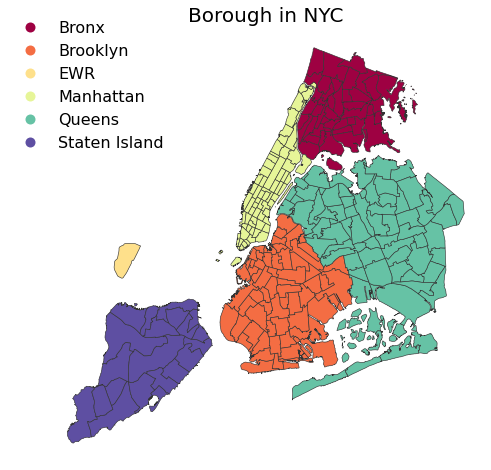

In [170]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_res_unit_df.plot(column='Borough', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Borough in NYC',fontsize=20)


Text(0.5, 1.0, 'Service Zone in NYC')

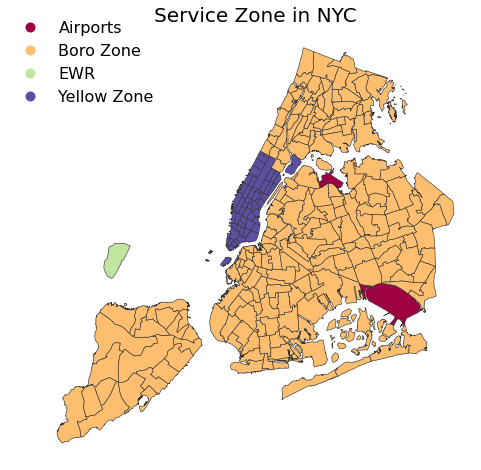

In [171]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_res_unit_df.plot(column='service_zone', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Service Zone in NYC',fontsize=20)



Text(0.5, 1.0, 'Number of Residential Units in NYC')

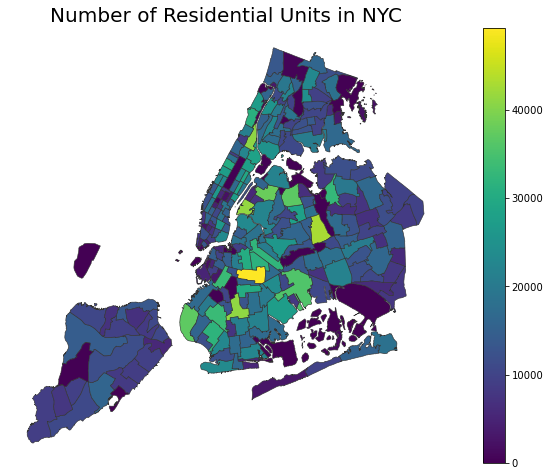

In [174]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_res_unit_df.plot(column='total_residential', categorical=False, linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax)
ax.axis('off')
ax.set_title('Number of Residential Units in NYC',fontsize=20)



Text(0.5, 1.0, 'Number of Residential Units in NYC')

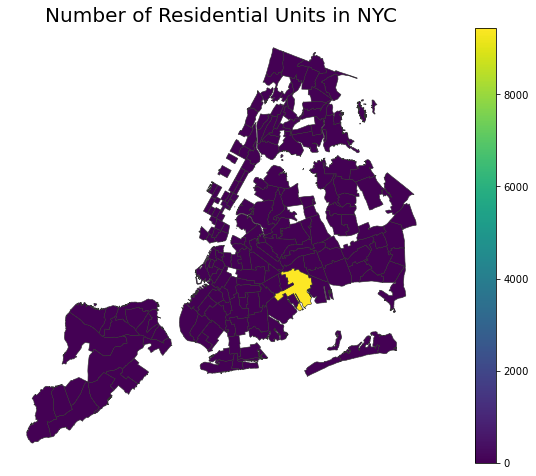

In [202]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_unit_df.plot(column='Z', categorical=False, linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax)
ax.axis('off')
ax.set_title('Number of Residential Units in NYC',fontsize=20)




In [205]:
total_unit_df[total_unit_df['Borough'] == 'Manhattan']['zone'].unique()

array(['Alphabet City', 'Battery Park', 'Battery Park City',
       'Bloomingdale', 'Central Harlem', 'Central Harlem North',
       'Central Park', 'Chinatown', 'Clinton East', 'Clinton West',
       'East Chelsea', 'East Harlem North', 'East Harlem South',
       'East Village', 'Financial District North',
       'Financial District South', 'Flatiron', 'Garment District',
       "Governor's Island/Ellis Island/Liberty Island", 'Gramercy',
       'Greenwich Village North', 'Greenwich Village South',
       'Hamilton Heights', 'Highbridge Park', 'Hudson Sq', 'Inwood',
       'Inwood Hill Park', 'Kips Bay', 'Lenox Hill East',
       'Lenox Hill West', 'Lincoln Square East', 'Lincoln Square West',
       'Little Italy/NoLiTa', 'Lower East Side', 'Manhattan Valley',
       'Manhattanville', 'Marble Hill', 'Meatpacking/West Village West',
       'Midtown Center', 'Midtown East', 'Midtown North', 'Midtown South',
       'Morningside Heights', 'Murray Hill',
       'Penn Station/Madison Sq W

In [228]:
total_res_unit_df[(total_res_unit_df['LocationID'] == 79)]

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,...,Z,U,Q,H,Y,I,R,J,T,total_residential
78,79,Manhattan,East Village,Yellow Zone,79,0.042625,0.000108,East Village,Manhattan,"POLYGON ((-73.98378 40.72154, -73.98382 40.721...",...,0.0,0.0,0.0,379.0,0.0,1.0,2546.0,5.0,NaN,26329.0


In [210]:
total_unit_df[(total_unit_df['Borough'] == 'Manhattan')]['LocationID'].unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 103, 107, 113, 114, 116, 120, 125, 127,
       128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161,
       162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261,
       262, 263])